# Galaxy non-galaxy adaptions - Notebook merged
In this notebook the following two notebooks are manually merged.
ViT_improved_models_galaxy_nongalaxy_classifiers.ipynb and ZM_improved_models_galaxy_nongalaxy_classifiers.ipynb

This notebook will only contain the copied adapted models from one of the codes mentioned before. For the original codes refer to one of the before mentioned notebooks.

The adapted models are merged in order to obtain one merged ROC curve plot with all the 6 models in it.


In [ ]:
#Import packages

import os
from sklearn.svm import SVC
from sklearn import metrics
import pickle
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

#Tensorflow
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import (Dense, Dropout,BatchNormalization, Input, Conv1D, Flatten,
                             MaxPooling1D)
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


#Scikit_learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, roc_auc_score, auc, log_loss,
                             precision_score, recall_score, f1_score,
                             accuracy_score, classification_report,
                             ConfusionMatrixDisplay, confusion_matrix)

In [ ]:
roc_curves = {}

In [ ]:
!pip install ZEMO
!pip install opencv-python

In [ ]:
from ZEMO import zemo
import cv2
from tqdm import tqdm  # Import tqdm for progress tracking

def calculate_zernike_moments(data_dir, image_size, zernike_order):

        ZBFSTR = zemo.zernike_bf(image_size, zernike_order, 1)

        image_files = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith('.jpg')]

        zernike_moments = []

        #for img_path in image_files:
        for img_path in tqdm(image_files, desc="Processing images", unit="image"):

            image = cv2.imread(img_path)
            resized_image = cv2.resize(image, (image_size,image_size))
            im = resized_image[:, :, 0]
            Z = np.abs(zemo.zernike_mom(np.array(im), ZBFSTR))
            zernike_moments.append(Z)

        df = pd.DataFrame(zernike_moments)

        return df

In [ ]:
data_path = r'/content/drive/Shared drives/DLP Project/Project/Data/'
nongalaxy_path = os.path.join(data_path, r'galaxy_nongalaxy/images/nongalaxy')
galaxy_path = os.path.join(data_path, r'galaxy_nongalaxy/images/galaxy')

# Default image size and zernike order.
image_size = 200
zernike_order = 45

In [ ]:
galaxy_zm = pd.read_csv('/content/drive/Shared drives/DLP Project/Project/galaxy_zms.csv')
nongalaxy_zm = pd.read_csv('/content/drive/Shared drives/DLP Project/Project/nongalaxy_zms.csv')

galaxy_zm.drop("Unnamed: 0", axis = 1, inplace = True)
nongalaxy_zm.drop("Unnamed: 0", axis = 1, inplace = True)

zmg = np.array(galaxy_zm)
zmng = np.array(nongalaxy_zm)

all_zm_data = np.concatenate([zmg,zmng])
len(zmg), len(zmng), len(all_zm_data)

(780, 555, 1335)

In [ ]:
galaxies_labels = np.zeros(len(zmg))
nongalaxy_labels = np.ones(len(zmng))
all_labels = np.concatenate([galaxies_labels, nongalaxy_labels])
len(all_labels)

1335

# Model SVM with adaptions, copy

In [ ]:
# SVM + ZMs

X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_zm_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=None)


In [ ]:
!pip install imblearn

In [ ]:
class_weights = {0: len(all_zm_data) / (2*len(zmg)), 1: len(all_zm_data) / (2*len(zmng))}
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, recall_score, precision_score, f1_score, accuracy_score
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
model = SVC(kernel='rbf', probability=True, C=1.5, gamma='scale',class_weight=class_weights)
gz2_training_model = model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

con = metrics.confusion_matrix(y_test, y_pred)
print(con)

[[159  39]
 [ 13 123]]


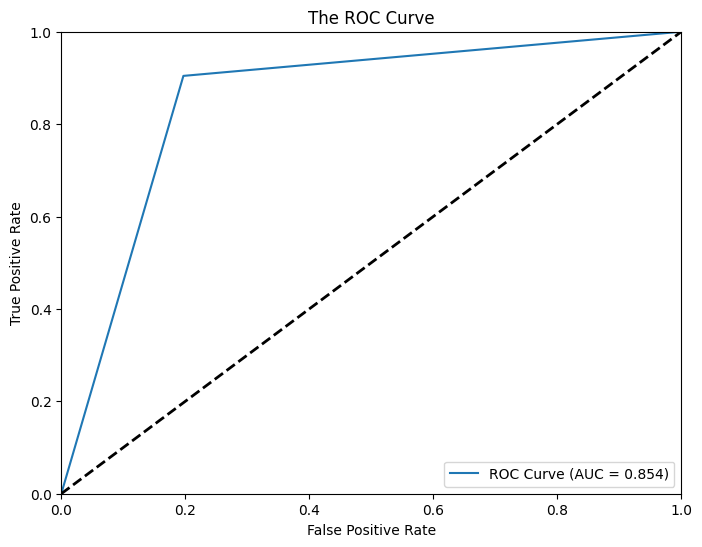

Recall: 0.844311377245509
Precision: 0.8571680927550582
F1_score: 0.8456330220024307
Accuracy: 0.844311377245509
TSS: 0.7074420677361855
AUC: 0.8537210338680926


In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)

class_names = ['Galaxy', 'None-Galaxy']

plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, lw=1.5, label='ROC Curve (AUC = {:.3f})'.format(auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The ROC Curve')
plt.legend(loc="lower right")
plt.show()


recall = recall_score(y_test, y_pred, average= 'weighted')
precision = precision_score(y_test, y_pred, average= 'weighted')
#f1_score = f1_score(y_test, y_pred, average= 'weighted')
f1 = f1_score(y_test, y_pred, average= 'weighted')
accuracy = accuracy_score(y_test, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tss=(tp/(tp+fn))-(fp/(fp+tn))



print("Recall:", recall)
print("Precision:", precision)
print("F1_score:", f1)
print("Accuracy:", accuracy)
print("TSS:", tss)
print("AUC:", auc)




[[157  42]
 [ 14 121]]
Confusion Matrix:
 [[157  42]
 [ 14 121]]
Recall: 0.896, Precision: 0.742, F1-Score: 0.812, Accuracy: 0.832, TSS: 0.685


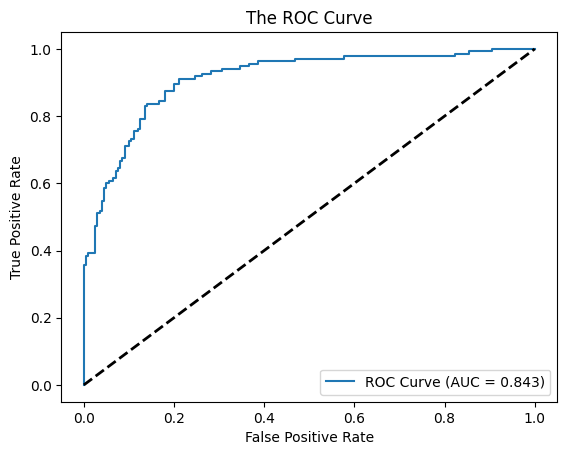

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

# Split data into train and test sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    all_zm_data, all_labels, np.arange(len(all_labels)), test_size=0.25, shuffle=True, random_state=None
)

# SMOTE
smote = SMOTE(sampling_strategy=0.9, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)  # Ensure SMOTE is applied correctly

# Compute class weights dynamically
class_weights = {0: len(all_zm_data) / (2 * len(zmg)), 1: len(all_zm_data) / (2 * len(zmng))}

# Train an SVM model
model = SVC(kernel='rbf', probability=True, C=1.5, gamma='scale', class_weight=class_weights)
gz2_training_model = model.fit(X_train, y_train)


y_pred = model.predict(X_test)

# Compute confusion matrix
con = metrics.confusion_matrix(y_test, y_pred)

# Compute ROC Curve and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, model.predict_proba(X_test)[:, 1])  # Use predict_proba for ROC
auc = metrics.roc_auc_score(y_test, y_pred)

# Define class names
class_names = ['Galaxy', 'None-Galaxy']

# Save ROC curves to plot them all together later
model_i_roc_curves = []

# If binary classification
if len(np.unique(y_test)) == 2:
    plt.plot(fpr, tpr, lw=1.5, label=f'ROC Curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for reference
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('The ROC Curve')
    plt.legend(loc="lower right")
    model_i_roc_curves.append((fpr, tpr, auc))

# Print confusion matrix
print(con)


# Compute metrics
conf_matrix = confusion_matrix(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
tss = (tp / (tp + fn)) - (fp / (fp + tn))

# Print results
print("Confusion Matrix:\n", conf_matrix)
print(f"Recall: {recall:.3f}, Precision: {precision:.3f}, F1-Score: {f1:.3f}, Accuracy: {accuracy:.3f}, TSS: {tss:.3f}")



In [ ]:
# Save the ROC curves of this model to the roc_curves dictionary
roc_curves['Model I'] = model_i_roc_curves

# Model 1D-CNN with adaptions, copy

In [ ]:
#1D_CNN + ZMs

X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_zm_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=None)

y_train_encoded = to_categorical(y_train, num_classes=2)

class_weights = {0: len(all_zm_data) / (2*len(zmg)), 1: len(all_zm_data) / (2*len(zmng))}

# input value
x = Input(shape=(all_zm_data.shape[1],1))

#hidden layers
c0 = Conv1D(256, kernel_size=3, strides=2, padding="same")(x)
b0 = BatchNormalization()(c0)
m0 = MaxPooling1D(pool_size=2)(b0)
d0 = Dropout(0.1)(m0)

c1 = Conv1D(128, kernel_size=3, strides=2, padding="same")(d0)
b1 = BatchNormalization()(c1)
m1 = MaxPooling1D(pool_size=2)(b1)
d1 = Dropout(0.1)(m1)

c2 = Conv1D(64, kernel_size=3, strides=2, padding="same")(d1)
b2 = BatchNormalization()(c2)
m2 = MaxPooling1D(pool_size=2)(b2)
d2 = Dropout(0.1)(m2)

f = Flatten()(d2)

# output
de0 = Dense(64, activation='relu')(f)
de1 = Dense(32, activation='relu')(de0)
de2 = Dense(2, activation='softmax')(de1)

model = Model(inputs=x, outputs=de2, name="cnn_zm_45_galaxy_nonegalaxy")
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "cnn_zm_45_galaxy_nonegalaxy"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 1081, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 541, 256)            │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 541, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 270, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 270, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 135, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 135, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 67, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 67, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 34, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 34, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 17, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 17, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 1088)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │          69,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,730 (772.38 KB)

 Trainable params: 196,834 (768.88 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Getting the initial weights of the model
initial_weights = model.get_weights()

# Resetting the model's weights - Issa
model.set_weights(initial_weights)

# Shuffle weights
for layer in model.layers:
    weights = layer.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    layer.set_weights(weights)

# Callback Function
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

b_size = 64
e_num = 30

history = model.fit(
X_train, y_train_encoded,
batch_size=b_size,
epochs=e_num,
class_weight=class_weights,
verbose = 1,
callbacks=es,
validation_split=0.1)



Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6836 - loss: 0.6520 - val_accuracy: 0.7030 - val_loss: 1.8102
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7916 - loss: 0.4518 - val_accuracy: 0.6733 - val_loss: 1.6624
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8024 - loss: 0.4220 - val_accuracy: 0.7327 - val_loss: 0.8482
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8547 - loss: 0.3462 - val_accuracy: 0.7030 - val_loss: 0.7346
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8719 - loss: 0.3222 - val_accuracy: 0.7525 - val_loss: 0.7228
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8639 - loss: 0.3724 - val_accuracy: 0.7129 - val_loss: 0.8613
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8690 - loss: 0.3264 - val_accuracy: 0.6931 - val_loss: 0.7126
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8728 - loss: 0.2964 - val_accuracy: 0.7822 - va

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Flatten, Dense, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Ensure X_train has the right shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# One-hot encoding is NOT needed, use sparse categorical loss
y_train = np.array(y_train)
y_test = np.array(y_test)

# Input layer
x = Input(shape=(X_train.shape[1], 1))

# Convolutional layers with regularization
c0 = Conv1D(256, kernel_size=3, strides=2, padding="same", kernel_regularizer=l2(0.001))(x)
b0 = BatchNormalization()(c0)
m0 = MaxPooling1D(pool_size=2)(b0)
d0 = Dropout(0.2)(m0)

c1 = Conv1D(128, kernel_size=3, strides=2, padding="same", kernel_regularizer=l2(0.001))(d0)
b1 = BatchNormalization()(c1)
m1 = MaxPooling1D(pool_size=2)(b1)
d1 = Dropout(0.2)(m1)

c2 = Conv1D(64, kernel_size=3, strides=2, padding="same", kernel_regularizer=l2(0.001))(d1)
b2 = BatchNormalization()(c2)
m2 = MaxPooling1D(pool_size=2)(b2)
d2 = Dropout(0.3)(m2)

# Fully connected layers
f = Flatten()(d2)
de0 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(f)
de1 = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(de0)
de2 = Dense(2, activation='softmax')(de1)

# Model compilation
model = Model(inputs=x, outputs=de2, name="cnn_galaxy_nonegalaxy")
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = Adam(learning_rate=0.001)  # Use learning rate scheduler later

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

# Early stopping and learning rate reduction
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Training parameters
b_size = 64
e_num = 50  # Increase epochs since we use regularization

# Train model
history = model.fit(
    X_train, y_train,
    batch_size=b_size,
    epochs=e_num,
    class_weight=class_weights,
    validation_split=0.1,
    verbose=1,
    callbacks=[es, lr_scheduler]
)


Model: "cnn_galaxy_nonegalaxy"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 1081, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 541, 256)            │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 541, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 270, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 270, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 135, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 135, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 67, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 67, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 34, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 34, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 17, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 17, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 1088)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │          69,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,730 (772.38 KB)

 Trainable params: 196,834 (768.88 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 432ms/step - accuracy: 0.6084 - loss: 1.4151 - val_accuracy: 0.5545 - val_loss: 3.0612 - learning_rate: 0.0010
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7590 - loss: 0.9310 - val_accuracy: 0.7327 - val_loss: 1.4604 - learning_rate: 0.0010
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7895 - loss: 0.8932 - val_accuracy: 0.7327 - val_loss: 1.4596 - learning_rate: 0.0010
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7617 - loss: 0.8802 - val_accuracy: 0.7228 - val_loss: 1.1141 - learning_rate: 0.0010
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8364 - loss: 0.8115 - val_accuracy: 0.7228 - val_loss: 1.0399 - learning_rate: 0.0010
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8166 - loss: 0.8139 - val_accuracy: 0.7327 - val_loss: 1.0089 - learning_rate: 0.0010
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8349 - loss: 0.7911 - val_a

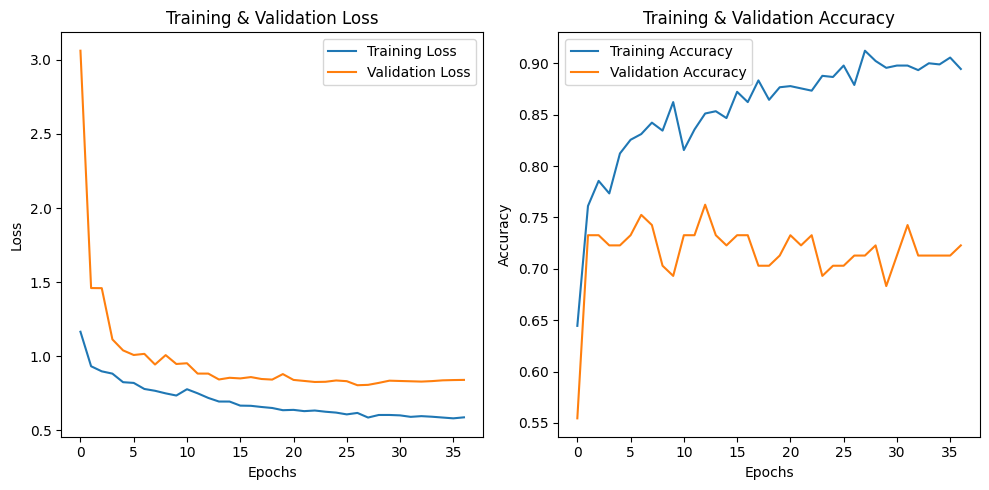

In [ ]:
import matplotlib.pyplot as plt

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


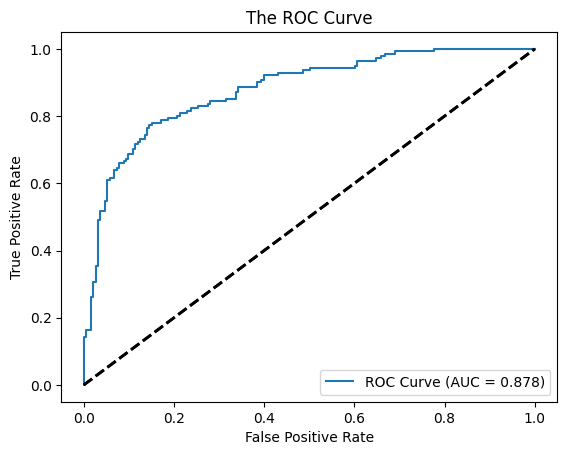

In [ ]:
# Get predicted probabilities for the positive class
y_pred_proba = model.predict(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)

# Compute AUC
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Class names for the labels
class_names = ['Galaxy', 'None-Galaxy']



# Save ROC curves
model_ii_roc_curves = []

if len(np.unique(y_test)) == 2:
    plt.plot(fpr, tpr, lw=1.5, label=f'ROC Curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for reference
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('The ROC Curve')
    plt.legend(loc="lower right")
    model_ii_roc_curves.append((fpr, tpr, auc))

# Plot diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', lw=2)



In [ ]:
# Save the ROC curves of this model to the roc_curves dictionary
roc_curves['Model II'] = model_ii_roc_curves

# Three models with Vision Transformer and original images:

In [ ]:
# import packages

import cv2
import os
import numpy as np
import random
from PIL import Image
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

#Tensorflow
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Input,Conv2D, Flatten,
                             MaxPooling2D,BatchNormalization)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, VGG16
from keras.callbacks import EarlyStopping

#Torch
import torch
import torch.nn as nn
from torchvision import transforms

In [ ]:
def load_galaxy_images(data_dir, target_size):

        """
        Loads, resizes, and processes all JPG images from the specified directory.

        Parameters:
        data_dir (str): The directory containing the JPG images to be processed.
        target_size (tuple): The target size for resizing the images, specified as (width, height).

        Returns:
        list: A list of PIL Image objects, each representing a resized and processed image.

        The function performs the following steps:
        1. Lists all JPG image files in the specified directory.
        2. Reads each image using OpenCV.
        3. Resizes each image to the specified target size.
        4. Scales the pixel values and converts the image to a format compatible with PIL.
        5. Converts each resized image to a PIL Image object.
        6. Appends each PIL Image object to a list.
        7. Returns the list of PIL Image objects.
        """

        all_images = []

        file_path = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith('.jpg')]

        for img in file_path:
            image = cv2.imread(img)
            resized_images=cv2.resize(image, target_size)
            resized_images = (resized_images * 255).astype(np.uint8)
            pil_images = Image.fromarray(resized_images)
            all_images.append(pil_images)

        return all_images

In [ ]:
nongalaxy_path = r'/content/drive/Shared drives/DLP Project/Project/Data/galaxy_nongalaxy/images/nongalaxy'
galaxy_path = r'/content/drive/Shared drives/DLP Project/Project/Data/galaxy_nongalaxy/images/galaxy'

image_size = 200

g_img = load_galaxy_images(galaxy_path, target_size=(image_size,image_size))
ng_img = load_galaxy_images(nongalaxy_path, target_size=(image_size,image_size))

all_data = g_img + ng_img
np.shape(all_data)

(1335, 200, 200, 3)

In [ ]:
# transforms for training data
train_transform = transforms.Compose([transforms.CenterCrop(image_size),
                                      transforms.RandomRotation(90),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])


# transforms for test data
test_transform = transforms.Compose([transforms.CenterCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])

In [ ]:
galaxy_labels = np.zeros(len(g_img))
nongalaxy_labels = np.ones(len(ng_img))

all_labels = np.concatenate([galaxy_labels, nongalaxy_labels])
len(all_labels)

1335

# Model 2D-CNN with adaptions, copy

In [ ]:
# CNN

X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=None)

y_train_encoded = to_categorical(y_train, num_classes=2)

In [ ]:
# Transformer for training data
transformed_X_train=[]
for i in range(len(X_train)):
  transformed_train_images = train_transform(X_train[i])
  new_image = np.transpose(transformed_train_images, (1, 2, 0))
  transformed_X_train.append(new_image)

# Transformer for testing data
transformed_X_test=[]
for j in range(len(X_test)):
  transformed_test_images = test_transform(X_test[j])
  new_images = np.transpose(transformed_test_images, (1, 2, 0))
  transformed_X_test.append(new_images)

In [ ]:
class_weights = {0: len(all_data) / (2*len(g_img)), 1: len(all_data) / (2*len(ng_img))}

In [ ]:
#Import packages

import os
from sklearn.svm import SVC
from sklearn import metrics
import pickle
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

#Tensorflow
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import (Dense, Dropout,BatchNormalization, Input, Conv1D, Flatten,
                             MaxPooling1D)
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


#Scikit_learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, roc_auc_score, auc, log_loss,
                             precision_score, recall_score, f1_score,
                             accuracy_score, classification_report,
                             ConfusionMatrixDisplay, confusion_matrix)

In [ ]:
#from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.regularizers import l2
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, recall_score, precision_score, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
class_weights = {0: len(all_data) / (2*len(g_img)), 1: len(all_data) / (2*len(ng_img))}

# Model with L2 Regularization and increased dropout
x = Input(shape=(image_size, image_size, 3))

c0 = Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
b0 = BatchNormalization()(c0)
m0 = MaxPooling2D(pool_size=(2, 2))(b0)
d0 = Dropout(0.3)(m0)  # Increased dropout

c1 = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding="same")(d0)
b1 = BatchNormalization()(c1)
m1 = MaxPooling2D(pool_size=(2, 2))(b1)
d1 = Dropout(0.3)(m1)

c2 = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding="same")(d1)
b2 = BatchNormalization()(c2)
m2 = MaxPooling2D(pool_size=(2, 2))(b2)
d2 = Dropout(0.3)(m2)

f = Flatten()(d2)

de0 = Dense(64, activation='relu')(f)
de1 = Dense(32, activation='relu')(de0)
de2 = Dense(2, activation='softmax')(de1)

model = Model(inputs=x, outputs=de2, name="cnn_transformer_galaxy_nonegalaxy")

# Compile Model
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optimizer = Adam(learning_rate=0.001)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# Callbacks
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Train the Model
history = model.fit(
    np.array(transformed_X_train), y_train_encoded,
    batch_size=64,
    epochs=50,
    class_weight=class_weights,
    validation_split=0.1,
    callbacks=[es, lr_scheduler, checkpoint],
    verbose=1
)

# Make Predictions
y_pred = model.predict(np.array(transformed_X_test))
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute and print metrics
conf_matrix = confusion_matrix(y_test, y_pred_labels)
fpr, tpr, _ = roc_curve(y_test, y_pred_labels)
auc = roc_auc_score(y_test, y_pred_labels)

print("Confusion Matrix:\n", conf_matrix)
print(f"ROC AUC: {auc:.3f}")

# Recall, Precision, F1, Accuracy
recall = recall_score(y_test, y_pred_labels, average='weighted')
precision = precision_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')
accuracy = accuracy_score(y_test, y_pred_labels)

#test_loss, test_acc = model.evaluate(np.array(transformed_X_test), y_test)
#print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}")


print(f"Recall: {recall:.3f}, Precision: {precision:.3f}, F1 Score: {f1:.3f}, Accuracy: {accuracy:.3f}")


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.5415 - loss: 6.8266
Epoch 1: val_loss improved from inf to 4.99444, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 818ms/step - accuracy: 0.5446 - loss: 6.6382 - val_accuracy: 0.6337 - val_loss: 4.9944 - learning_rate: 0.0010
Epoch 2/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.7003 - loss: 0.8957
Epoch 2: val_loss improved from 4.99444 to 0.93434, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 415ms/step - accuracy: 0.6994 - loss: 0.8748 - val_accuracy: 0.6634 - val_loss: 0.9343 - learning_rate: 0.0010
Epoch 3/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.7331 - loss: 0.5755
Epoch 3: val_loss improved from 0.93434 to 0.48968, saving model to best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 412ms/step - accuracy: 0.7328 - loss: 0.5768 - val_accuracy: 0.7822 - val_loss: 0.4897 - learning_rate: 0.0010
Epoch 4/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.7131 - loss: 0.5603
Epoch 4: val_loss did not improve from 0.48968
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 402ms/step - accuracy: 0.7142 - loss: 0.5620 - val_accuracy: 0.5149 - val_loss: 1.2373 - learning_rate: 0.0010
Epoch 5/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.6250 - loss: 0.7407
Epoch 5: val_loss did not improve from 0.48968
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 404ms/step - accuracy: 0.6328 - loss: 0.7264 - val_accuracy: 0.5545 - val_loss: 0.7793 - learning_rate: 0.0010
Epoch 6/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.7784 - loss: 0.4678
Epoch 6: val_loss did not improve from 0.48968
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 413ms/step - accuracy: 0.7805 - loss: 0.4637 - val_accuracy: 0.7822 - val_loss: 0.5262 - learning_rate: 0.0010
Epoch 7/50
14/15 ━━━━━━━━━━━━━━━━

In [ ]:
transformed_X_test = np.array(transformed_X_test, dtype=np.float32)
y_pred = model.predict(transformed_X_test)  # Get probability outputs
y_pred_proba = y_pred[:, 1]  # Extract probability of class 1 (Galaxy)
y_pred_labels = np.argmax(y_pred, axis=1)  # Get hard predictions

# Correct ROC and AUC calculation
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)  # Use probabilities, not hard labels
auc = metrics.roc_auc_score(y_test, y_pred_proba)
#fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_labels)

#auc = metrics.roc_auc_score(y_test, y_pred_labels)
precision = metrics.precision_score(y_test, y_pred_labels, average='weighted')
recall = metrics.recall_score(y_test, y_pred_labels, average='weighted')
f1 = metrics.f1_score(y_test, y_pred_labels, average='weighted')
accuracy = metrics.accuracy_score(y_test, y_pred_labels)


# Print metrics
tn, fp, fn, tp = conf_matrix.ravel()
tss = (tp / (tp + fn)) - (fp / (fp + tn))

print(f"Recall: {recall:.3f}")
print(f"Precision: {precision:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print(f"TSS: {tss:.3f}")
print(f"AUC: {auc:.3f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Recall: 0.796
Precision: 0.805
F1 Score: 0.789
Accuracy: 0.796
TSS: 0.542
AUC: 0.858


In [ ]:
print(type(transformed_X_test))

<class 'numpy.ndarray'>


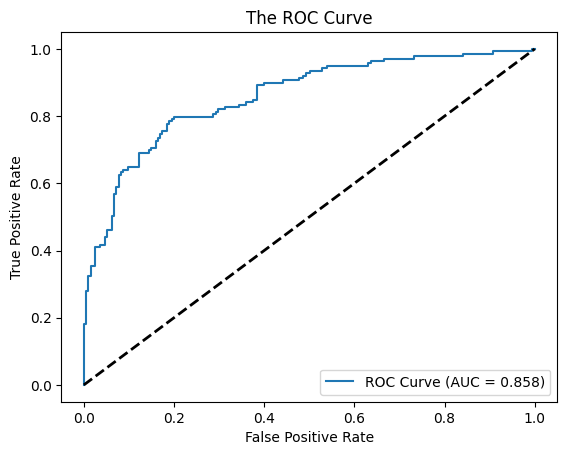

In [ ]:
# Save ROC curves
model_iii_roc_curves = []

# Plotting the ROC curve for each class

if len(np.unique(y_test)) == 2:
    plt.plot(fpr, tpr, lw=1.5, label=f'ROC Curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for reference
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('The ROC Curve')
    plt.legend(loc="lower right")
    model_iii_roc_curves.append((fpr, tpr, auc))


In [ ]:
# Save the ROC curves of this model to the roc_curves dictionary
roc_curves['Model III'] = model_iii_roc_curves

In [ ]:
from tensorflow.keras.utils import to_categorical
y_test_encoded = to_categorical(y_test, num_classes=2)
y_train_encoded = to_categorical(y_train, num_classes=2)
# Compute test accuracy and test loss
test_loss, test_accuracy = model.evaluate(np.array(transformed_X_test), y_test_encoded, verbose=0)

# Compute training accuracy and training loss
train_loss, train_accuracy = model.evaluate(np.array(transformed_X_train), y_train_encoded, verbose=0)


print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")


Training Loss: 0.584, Training Accuracy: 0.685
Test Loss: 0.482, Test Accuracy: 0.796


# Model ResNet with adaptions, copy

In [ ]:
galaxy_labels = np.zeros(len(g_img))
nongalaxy_labels = np.ones(len(ng_img))

all_labels = np.concatenate([galaxy_labels, nongalaxy_labels])
len(all_labels)

1335

In [ ]:
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=None)

y_train_encoded = to_categorical(y_train, num_classes=2)

In [ ]:
# Transformer for training data
transformed_X_train=[]
for i in range(len(X_train)):
  transformed_train_images = train_transform(X_train[i])
  new_image = np.transpose(transformed_train_images, (1, 2, 0))
  transformed_X_train.append(new_image)

# Transformer for testing data
transformed_X_test=[]
for j in range(len(X_test)):
  transformed_test_images = test_transform(X_test[j])
  new_images = np.transpose(transformed_test_images, (1, 2, 0))
  transformed_X_test.append(new_images)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 911ms/step - accuracy: 0.5413 - loss: 7.3768 - val_accuracy: 0.5941 - val_loss: 0.6709 - learning_rate: 0.0010
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.6191 - loss: 0.6423 - val_accuracy: 0.5941 - val_loss: 0.6757 - learning_rate: 0.0010
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.5999 - loss: 0.6414 - val_accuracy: 0.6139 - val_loss: 0.7722 - learning_rate: 0.0010
Epoch 4/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.6389 - loss: 0.5921
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.6411 - loss: 0.5900 - val_accuracy: 0.5941 - val_loss: 0.7974 - learning_rate: 0.0010
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.7388 - loss: 0.5236 - val_accuracy: 0.5941 - val_loss: 0.7192 - learning_rate: 5.0000e-04
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.7573 - loss: 0.496

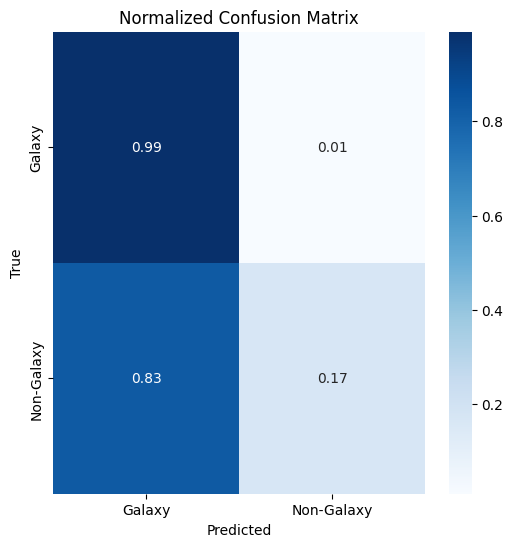

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Recall: 0.629
Precision: 0.745
F1 Score: 0.546
Accuracy: 0.629
TSS: 0.159
AUC: 0.707


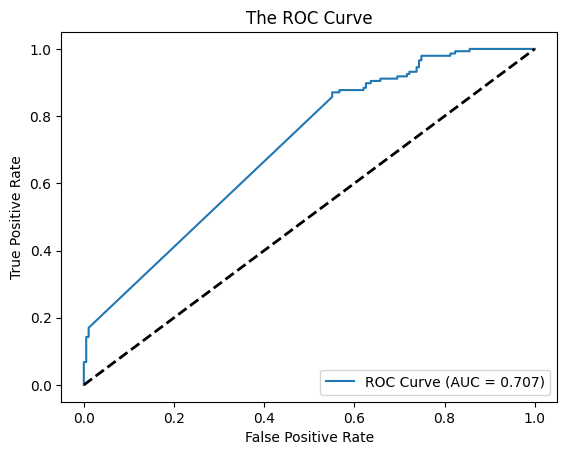

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns



# Convert labels to categorical
y_train_encoded = to_categorical(y_train, num_classes=2)


# Define class weights to handle class imbalance
class_weights = {0: len(all_data) / (2*len(g_img)), 1: len(all_data) / (2*len(ng_img))}

# Load ResNet50 as base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all layers in ResNet50 to avoid overfitting
for layer in base_model.layers:
    layer.trainable = False

# Build the custom model
x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)  # Custom layer
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define EarlyStopping and LearningRate Scheduler
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Train the model

history = model.fit(
np.array(transformed_X_train), y_train_encoded,
batch_size=b_size,
epochs=e_num,
verbose = 1,
callbacks=[es, lr_scheduler],
class_weight=class_weights,
validation_split=0.1
)

# Evaluate the model
y_pred = model.predict(np.array(transformed_X_test))
y_pred_labels = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred_labels)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
class_names = ['Galaxy', 'Non-Galaxy']
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()


# Evaluate model
transformed_X_test = np.array(transformed_X_test)
y_pred = model.predict(transformed_X_test)  # Get probability outputs
y_pred_proba = y_pred[:, 1]  # Extract probability of class 1 (Galaxy)
y_pred_labels = np.argmax(y_pred, axis=1)  # Get hard predictions

# Correct ROC and AUC calculation
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)  # Use probabilities, not hard labels
auc = metrics.roc_auc_score(y_test, y_pred_proba)


# Metrics calculation
precision = metrics.precision_score(y_test, y_pred_labels, average='weighted')
recall = metrics.recall_score(y_test, y_pred_labels, average='weighted')
f1 = metrics.f1_score(y_test, y_pred_labels, average='weighted')
accuracy = metrics.accuracy_score(y_test, y_pred_labels)



# Save ROC curves
model_iv_roc_curves = []

# Plotting the ROC curve for each class

if len(np.unique(y_test)) == 2:
    plt.plot(fpr, tpr, lw=1.5, label=f'ROC Curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for reference
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('The ROC Curve')
    plt.legend(loc="lower right")
    model_iv_roc_curves.append((fpr, tpr, auc))

# Print metrics
tn, fp, fn, tp = conf_matrix.ravel()
tss = (tp / (tp + fn)) - (fp / (fp + tn))

print(f"Recall: {recall:.3f}")
print(f"Precision: {precision:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print(f"TSS: {tss:.3f}")
print(f"AUC: {auc:.3f}")


In [ ]:
# Save the ROC curves of this model to the roc_curves dictionary
roc_curves['Model IV'] = model_iv_roc_curves

In [ ]:
# Final training loss and accuracy
final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]

# Final validation loss and accuracy
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

# Print the final results
print("Final Training Loss:", final_train_loss)
print("Final Training Accuracy:", final_train_accuracy)
print("Final Validation Loss:", final_val_loss)
print("Final Validation Accuracy:", final_val_accuracy)


Final Training Loss: 0.3959628939628601
Final Training Accuracy: 0.846666693687439
Final Validation Loss: 0.850637674331665
Final Validation Accuracy: 0.7029703259468079


In [ ]:
# Compute test accuracy and test loss
test_loss, test_accuracy = model.evaluate(np.array(transformed_X_test), y_test_encoded, verbose=0)

# Compute training accuracy and training loss
train_loss, train_accuracy = model.evaluate(np.array(transformed_X_train), y_train_encoded, verbose=0)


print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")


Training Loss: 0.671, Training Accuracy: 0.603
Test Loss: 0.983, Test Accuracy: 0.563


# Model ResNext, new model so no adaptions, copy.

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 71s 593ms/step - accuracy: 0.5090 - loss: 1.0259 - val_accuracy: 0.4950 - val_loss: 0.7016 - learning_rate: 0.0010
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 331ms/step - accuracy: 0.5249 - loss: 0.6925 - val_accuracy: 0.5842 - val_loss: 0.6716 - learning_rate: 0.0010
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 337ms/step - accuracy: 0.5803 - loss: 0.6723 - val_accuracy: 0.5347 - val_loss: 0.6962 - learning_rate: 0.0010
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 347ms/step - accuracy: 0.6171 - loss: 0.6300 - val_accuracy: 0.5050 - val_loss: 0.6870 - learning_rate: 0.0010
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 341ms/step - accuracy: 0.6151 - loss: 0.6378 - val_accuracy: 0.6832 - val_loss: 0.6488 - learning_rate: 0.0010
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 331ms/step - accuracy: 0.7597 - loss: 0.5108 - val_accuracy: 0.6436 - val_loss: 0.6877 - learning_rate: 0.0010
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 334ms/step - accuracy: 0.7233 - loss: 0.

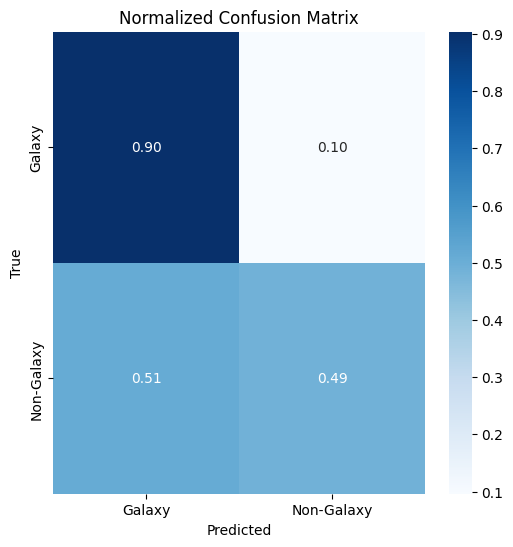

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step
Recall: 0.722
Precision: 0.740
F1 Score: 0.706
Accuracy: 0.722
TSS: 0.394
AUC: 0.757


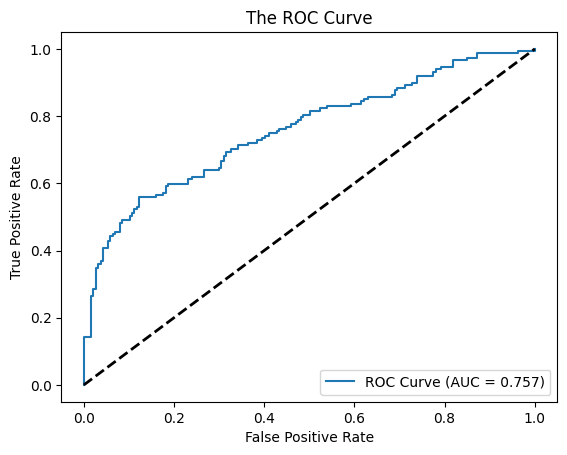

In [ ]:
# RESNEXT

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# Define the ResNeXt block
class ResNeXtBlock(layers.Layer):
    def __init__(self, filters, cardinality, stride=1):
        super(ResNeXtBlock, self).__init__()
        self.cardinality = cardinality
        self.conv1x1_1 = layers.Conv2D(filters, kernel_size=1, padding='same')
        self.conv3x3 = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', groups=cardinality)
        self.conv1x1_2 = layers.Conv2D(filters, kernel_size=1, padding='same')
        self.bn = layers.BatchNormalization()

        # If the stride is greater than 1, we downsample the residual
        self.residual_conv = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')
        self.residual_bn = layers.BatchNormalization()

    def call(self, inputs):
        residual = inputs
        x = self.conv1x1_1(inputs)
        x = layers.ReLU()(x)
        x = self.conv3x3(x)
        x = layers.ReLU()(x)
        x = self.conv1x1_2(x)
        x = self.bn(x)


        residual = self.residual_conv(residual)
        residual = self.residual_bn(residual)

        return layers.add([x, residual])  # Adding the residual to the output

# Define the ResNeXt architecture
class ResNeXt(models.Model):
    def __init__(self, num_blocks, cardinality, num_classes=2):
        super(ResNeXt, self).__init__()
        self.conv1 = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', input_shape=(None, None, 3))
        self.bn1 = layers.BatchNormalization()
        self.layer1 = self.make_layer(64, num_blocks[0], cardinality, stride=1)
        self.layer2 = self.make_layer(128, num_blocks[1], cardinality, stride=2)
        self.layer3 = self.make_layer(256, num_blocks[2], cardinality, stride=2)
        self.global_pool = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(num_classes, activation='softmax')

    def make_layer(self, filters, num_blocks, cardinality, stride):
        layers_list = []
        for _ in range(num_blocks):
            layers_list.append(ResNeXtBlock(filters, cardinality, stride))
        return models.Sequential(layers_list)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = layers.ReLU()(x)
        x = self.bn1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.global_pool(x)
        x = self.fc(x)
        return x

# Hyperparameters
num_blocks = [3, 4, 6]  # Number of blocks in each layer
cardinality = 8  # Cardinality (number of parallel paths in each group)

# Convert labels to categorical
y_train_encoded = to_categorical(y_train, num_classes=2)

# Define class weights to handle class imbalance
class_weights = {0: len(all_data) / (2 * len(g_img)), 1: len(all_data) / (2 * len(ng_img))}

# Initialize the ResNeXt model
model = ResNeXt(num_blocks=num_blocks, cardinality=cardinality, num_classes=2)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping and Learning Rate Scheduler
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Train the model
history = model.fit(
    np.array(transformed_X_train), y_train_encoded,
    batch_size=16,
    epochs=e_num,
    verbose=1,
    callbacks=[es, lr_scheduler],
    class_weight=class_weights,
    validation_split=0.1
)

# Evaluate the model
y_pred = model.predict(np.array(transformed_X_test))
y_pred_labels = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred_labels)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
class_names = ['Galaxy', 'Non-Galaxy']
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

y_pred = model.predict(transformed_X_test)  # Get probability outputs
y_pred_proba = y_pred[:, 1]  # Extract probability of class 1 (Galaxy)
y_pred_labels = np.argmax(y_pred, axis=1)  # Get hard predictions

# Correct ROC and AUC calculation
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)  # Use probabilities, not hard labels
auc = metrics.roc_auc_score(y_test, y_pred_proba)


# Metrics calculation
#fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_labels)
#auc = metrics.roc_auc_score(y_test, y_pred_labels)
precision = metrics.precision_score(y_test, y_pred_labels, average='weighted')
recall = metrics.recall_score(y_test, y_pred_labels, average='weighted')
f1 = metrics.f1_score(y_test, y_pred_labels, average='weighted')
accuracy = metrics.accuracy_score(y_test, y_pred_labels)

# Save ROC curves
model_resnext_roc_curves = []

# Plotting the ROC curve for each class

if len(np.unique(y_test)) == 2:
    plt.plot(fpr, tpr, lw=1.5, label=f'ROC Curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('The ROC Curve')
    plt.legend(loc="lower right")
    model_resnext_roc_curves.append((fpr, tpr, auc))

# Print metrics
tn, fp, fn, tp = conf_matrix.ravel()
tss = (tp / (tp + fn)) - (fp / (fp + tn))

print(f"Recall: {recall:.3f}")
print(f"Precision: {precision:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print(f"TSS: {tss:.3f}")
print(f"AUC: {auc:.3f}")


In [ ]:
# Save the ROC curves of this model to the roc_curves dictionary
roc_curves['Model resnext'] = model_resnext_roc_curves

# Model for VGG16 adaptions, copy

In [ ]:
#VGG16

galaxy_labels = np.zeros(len(g_img))
nongalaxy_labels = np.ones(len(ng_img))

all_labels = np.concatenate([galaxy_labels, nongalaxy_labels])
len(all_labels)

X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_data, all_labels, np.arange(len(all_labels)),
                                                                                 test_size=0.25, shuffle=True, random_state=None)

y_train_encoded = to_categorical(y_train, num_classes=2)


# Transformer for training data
transformed_X_train=[]
for i in range(len(X_train)):
  transformed_train_images = train_transform(X_train[i])
  new_image = np.transpose(transformed_train_images, (1, 2, 0))
  transformed_X_train.append(new_image)

# Transformer for testing data
transformed_X_test=[]
for j in range(len(X_test)):
  transformed_test_images = test_transform(X_test[j])
  new_images = np.transpose(transformed_test_images, (1, 2, 0))
  transformed_X_test.append(new_images)

  class_weights = {0: len(all_data) / (2*len(g_img)), 1: len(all_data) / (2*len(ng_img))}

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 27s 636ms/step - accuracy: 0.6470 - loss: 0.7785 - val_accuracy: 0.6040 - val_loss: 2.1427 - learning_rate: 1.0000e-04
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 438ms/step - accuracy: 0.7229 - loss: 0.5682 - val_accuracy: 0.6040 - val_loss: 7.9725 - learning_rate: 1.0000e-04
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - accuracy: 0.8116 - loss: 0.4602 - val_accuracy: 0.6040 - val_loss: 6.4360 - learning_rate: 1.0000e-04
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 430ms/step - accuracy: 0.7924 - loss: 0.4739 - val_accuracy: 0.6238 - val_loss: 3.1742 - learning_rate: 1.0000e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 433ms/step - accuracy: 0.8256 - loss: 0.3808 - val_accuracy: 0.6634 - val_loss: 1.2052 - learning_rate: 1.0000e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 444ms/step - accuracy: 0.8591 - loss: 0.3068 - val_accuracy: 0.6139 - val_loss: 2.7433 - learning_rate: 1.0000e-04
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 438ms/step - acc

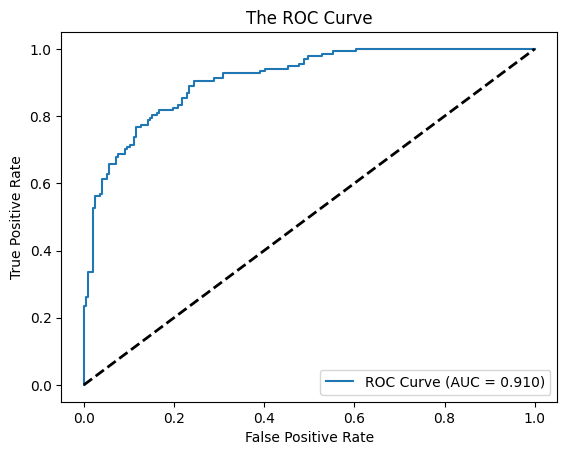

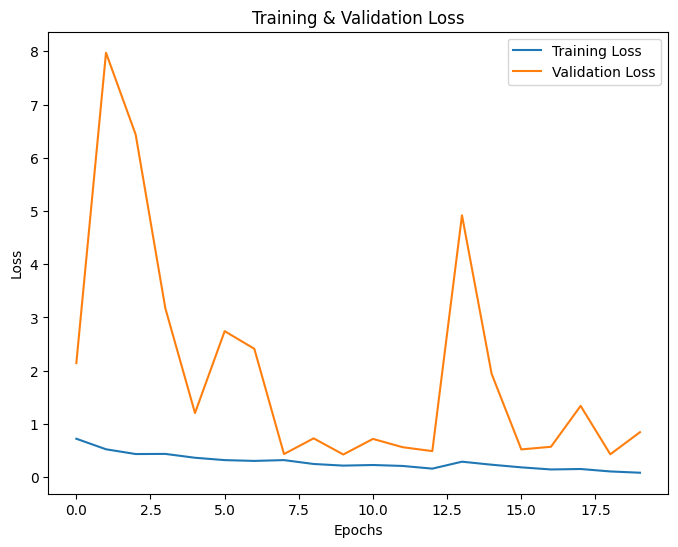

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, recall_score, precision_score, f1_score, accuracy_score

# Load and preprocess labels
galaxy_labels = np.zeros(len(g_img))
nongalaxy_labels = np.ones(len(ng_img))
all_labels = np.concatenate([galaxy_labels, nongalaxy_labels])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.25, shuffle=True, random_state=42)

# One-hot encode labels
y_train_encoded = to_categorical(y_train, num_classes=2)
y_test_encoded = to_categorical(y_test, num_classes=2)

# Transform images
transformed_X_train = np.array([np.transpose(train_transform(img), (1, 2, 0)) for img in X_train])
transformed_X_test = np.array([np.transpose(test_transform(img), (1, 2, 0)) for img in X_test])

# Compute class weights
class_weights = {0: len(all_data) / (2 * len(g_img)), 1: len(all_data) / (2 * len(ng_img))}

# Define model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Reduce overfitting
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)#
output = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train model
history = model.fit(
    transformed_X_train, y_train_encoded,
    batch_size=32,
    epochs=50,
    validation_split=0.1,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate model
y_pred = model.predict(transformed_X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Compute metrics
recall = recall_score(y_test, y_pred_labels, average='weighted')
precision = precision_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')
accuracy = accuracy_score(y_test, y_pred_labels)
auc = roc_auc_score(y_test, y_pred_labels)

# Print results
print("Confusion Matrix:\n", conf_matrix)
print(f"Recall: {recall:.3f}, Precision: {precision:.3f}, F1-Score: {f1:.3f}, Accuracy: {accuracy:.3f}, AUC: {auc:.3f}")


y_pred = model.predict(np.array(transformed_X_test))
y_pred_proba = y_pred[:, 1]  # Extract probability for class 1 (Galaxy)
y_pred_labels = np.argmax(y_pred, axis=1)  # Keep this for confusion matrix

# Correct ROC/AUC calculation
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)


# Save ROC curves
model_v_roc_curves = []

# Plotting the ROC curve for each class

if len(np.unique(y_test)) == 2:
    plt.plot(fpr, tpr, lw=1.5, label=f'ROC Curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for reference
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('The ROC Curve')
    plt.legend(loc="lower right")
    model_v_roc_curves.append((fpr, tpr, auc))

fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])

# Training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()


In [ ]:
# Save the ROC curves of this model to the roc_curves dictionary
roc_curves['Model V'] = model_v_roc_curves

In [ ]:
# Compute test accuracy and test loss
test_loss, test_accuracy = model.evaluate(np.array(transformed_X_test), y_test_encoded, verbose=0)

# Compute training accuracy and training loss
train_loss, train_accuracy = model.evaluate(np.array(transformed_X_train), y_train_encoded, verbose=0)

# Print training vs test performance
print(f"Training Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")


Training Loss: 0.534, Training Accuracy: 0.719
Test Loss: 0.733, Test Accuracy: 0.707


# Merging all the ROC curves


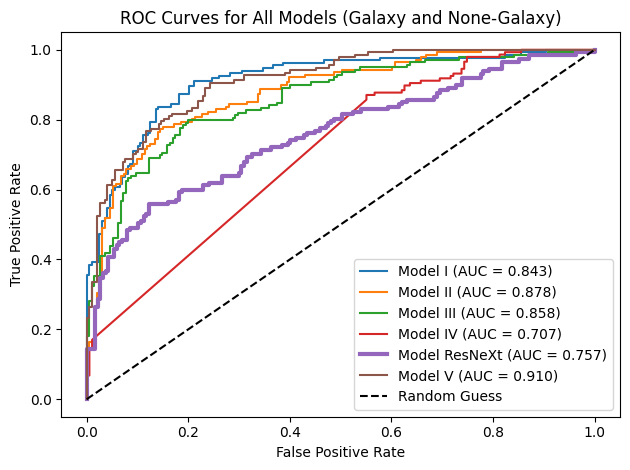

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



roc_curves = {
    "Model I": model_i_roc_curves,
    "Model II": model_ii_roc_curves,
    "Model III": model_iii_roc_curves,
    "Model IV": model_iv_roc_curves,
    "Model ResNeXt": model_resnext_roc_curves,
    'Model V': model_v_roc_curves
}

plt.figure(dpi=100)

# Iterate over models to plot all ROC curves
for model_name, class_roc_curves in roc_curves.items():
    for i, class_roc in enumerate(class_roc_curves):
        # Get the ROC curve components: mean_fpr, mean_tpr, and mean_auc
        mean_fpr = class_roc[0]
        mean_tpr = class_roc[1]
        mean_auc = class_roc[2]

        #line_style = 'dashdot' if model_name == "Model resnext" else '-'
        line_width = 3.0 if model_name == "Model ResNeXt" else 1.5

        # \ROC curve for the current model and class
        plt.plot(mean_fpr, mean_tpr, label=f'{model_name} (AUC = {mean_auc:.3f})', lw=line_width)

#random guess diagonal
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')


plt.title('ROC Curves for All Models (Galaxy and None-Galaxy)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')


plt.tight_layout()

plt.savefig('all_models_roc.png')

# Display the plot
plt.show()
